# Determining sampling strategy for the dataset

I will sample 10 x 10km squares area. I need to know at which level (communities or clusters) I need to realize the sampling. I will use the following approach:
1. I will compute the distribution of communities
2. I will compute the distribution of clusters
3. Depending on the distribution, I will decide the level of sampling
4. Depending on the distribution of cluster size, I might be obliged to sample subparts of clusters. 

In [2]:
#load datasets
import geopandas as gpd
import pandas as pd
#add '../join-datasets' to the path
import sys
sys.path.append('../join-datasets')
from constants import loading_dict, temporal_buffer, ddataset_profile, ddisturbance_profile, DCLASS_SCORE, dtypes, doa, dsbuffer

ddataset = {dataset_name : gpd.read_parquet(dataset_path) for dataset_name, dataset_path in loading_dict.items()}

#preprocessing tcl:
tcl = gpd.read_parquet('../data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')
tcl['year'] = tcl['year'] + 2000
tcl['class'] = None

#preprocessing bdiff:

ddataset['firepolygons']['class'] = 'Fire'
#add end date with offset of 7 days 
ddataset['firepolygons']['end_date'] = pd.to_datetime(ddataset['firepolygons']['start_date']) + pd.to_timedelta(7, unit='d')

ddataset['bdiff']['class'] = 'Fire'
ddataset['bdiff'] = ddataset['bdiff'][ ddataset['bdiff'].forest_area_m2 > 5000 ]
#create function that convert column 'start_date' to pd.datetime with the following format : '%Y-%m-%d',
#filter bdiff geometry area < 100 1e6  m2
ddataset['bdiff'] = ddataset['bdiff'][ ddataset['bdiff'].geometry.area <= 100e6 ]
#same for cdi 
ddataset['cdi'] = ddataset['cdi'][ ddataset['cdi'].geometry.area <= 100e6 ]
#create function that convert column 'start_date' to pd.datetime with the following format : '%Y-%m-%d', 
# if the 'start_date' is just mentionning the time and not the date, use the year column to create a start_date and end_date column as the first and last day of this year
#create this function as 'to_datetime_safe', it takes as input a row of a dataframe
def to_datetime_safe(row):
    try :
        return pd.to_datetime(row['start_date'], format='%Y-%m-%d'), pd.to_datetime(row['start_date'], format='%Y-%m-%d')
    except ValueError:
        return pd.to_datetime(row['year'], format='%Y'), pd.to_datetime(row['year'], format='%Y') + pd.offsets.YearEnd(0)


ddataset['bdiff'][['start_date', 'end_date']] = ddataset['bdiff'].apply(to_datetime_safe, axis=1, result_type='expand')

#autoreload 
from attribution2 import Attribution
attribution = Attribution(ddataset, reference=tcl, doa=doa, dtypes=dtypes, 
                          temporal_buffer=temporal_buffer, dsbuffer=dsbuffer, 
                          dclass_score=DCLASS_SCORE, granularity=5, 
                          ddataset_profile=ddataset_profile, ddisturbance_profile=ddisturbance_profile, 
                          start_year=2017)

filter_class = set()
for dataset, dclass in DCLASS_SCORE.items():
    for class_ in dclass:
        if 'storm' in dclass[class_] or 'fire' in dclass[class_]:
            filter_class.add(class_)

## 1. Distribution of communities size

In [3]:
#load communities 
mode = 'equal'
resolution = 100
dim = 2
temporal_threshold_ = 180 * 2
spatial_threshold_  = 600

all_disturbances = gpd.read_parquet(f"../data/results/clusters/communities_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}.parquet")

#filter disturbances by date 
#end_date should be greater than 2015 and and start_date should be less than 2020 
all_disturbances = all_disturbances[all_disturbances.end_date.dt.year >= 2017]
all_disturbances = all_disturbances[all_disturbances.start_date.dt.year <= 2020]

#dissolve by 'cluster'
communities = all_disturbances.dissolve(by='cluster', aggfunc='first')

In [4]:
#creating bounding boxes
from shapely.geometry import box 
#use itertuples to create a list of boxes from bounds of each geometry
boxes = [box(*row.geometry.bounds) for row in communities.itertuples()]

#create GeoDataFrame from the list of boxes
boxes = gpd.GeoDataFrame(geometry=boxes, crs=communities.crs)

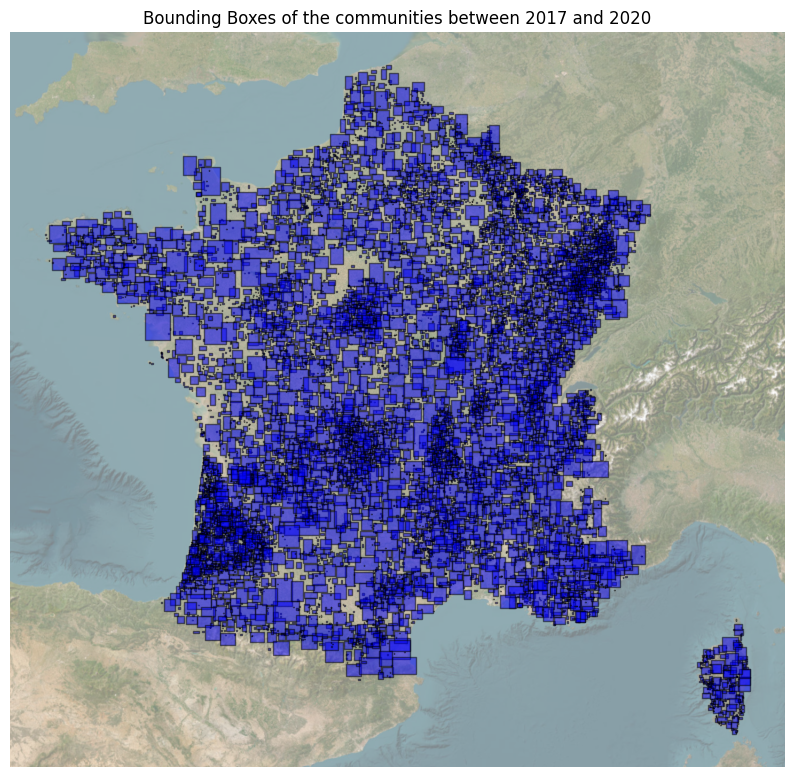

In [5]:
#plot the boxes
#make a nice plot with fig, ax
import matplotlib.pyplot as plt
import contextily as ctx
fig, ax = plt.subplots(figsize=(10, 10))
boxes.plot(ax=ax, color='blue', edgecolor='black', alpha=0.5)
ax.set_title('Bounding Boxes of the communities between 2017 and 2020')
ax.set_axis_off()
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, attribution=False, crs=communities.crs.to_string(), alpha=0.5)
fig.savefig('../figures/bounding_boxes_comnunities2.png', dpi=300, bbox_inches='tight')

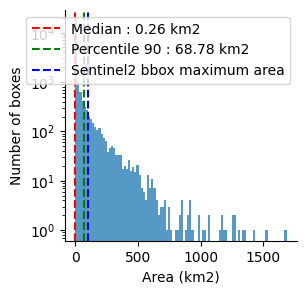

In [6]:
#from geodataframe of boxes, 
#compute the area of each geometry, convert it to square kilometers and add it to the geodataframe as a new column 'area_km2'
boxes['area_km2'] = boxes.area / 10**6

#plot the distribution of the area of the boxes in logscale
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(3, 3))
ax.hist(boxes.area_km2, bins=100, log=True, alpha=0.75)
ax.set_xlabel('Area (km2)')
ax.set_ylabel('Number of boxes')

#add median and percentile 90 to the plot WITH THEIR VALUES in label 
median = boxes.area_km2.median()
percentile_90 = boxes.area_km2.quantile(0.9)
ax.axvline(median, color='r', linestyle='--', label=f'Median : {median:.2f} km2')
ax.axvline(percentile_90, color='g', linestyle='--', label=f'Percentile 90 : {percentile_90:.2f} km2')
#add vertical line at 100 for maximum bounding box area with sentinel2 for labelling
ax.axvline(100, color='b', linestyle='--', label='Sentinel2 bbox maximum area')
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig('../figures/area_distribution_communities2.png', dpi=300, bbox_inches='tight')

## 2. Distribution of clusters size

In [12]:
method = 'HDBSCAN'
clusters = gpd.read_parquet(f"../data/results/clusters/clusters_{method}_m{mode}_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}.parquet")
#reindex and called previous index 'cluster'
clusters = clusters.reset_index().rename(columns={'index':'cluster'})

#filter clusters by date, End_date year should be greater than 2017 and Start_Date year should be less than 2020
clusters = clusters[clusters.End_Date.dt.year >= 2017]
clusters = clusters[clusters.Start_Date.dt.year <= 2020]

In [8]:
clusters = clusters[ (clusters.Spatial_threshold >= 0.1) & (clusters.Temporal_threshold >= 0.1) ]

In [13]:
#count percentage of -1 in the cluster column
percentage_noise = (clusters.cluster == -1).mean()
print(f'Percentage of noise : {percentage_noise:.2%}')

Percentage of noise : 10.74%


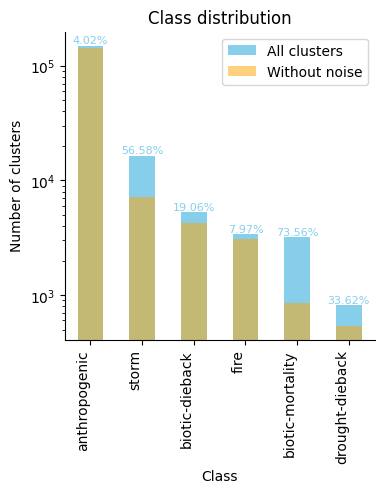

In [14]:
#histogram of Class distribution
fig, ax = plt.subplots(figsize=(4, 4))
clusters['Class'].value_counts().plot(kind='bar', ax=ax, logy=True, color='skyblue')
ax.set_title('Class distribution')
ax.set_xlabel('Class')
ax.set_ylabel('Number of clusters')
#rotate x label at 45
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#on the same figure, the same distirbution but by filtering cluster without noise
clusters[clusters.cluster != -1]['Class'].value_counts().plot(kind='bar', ax=ax, logy=True, color='orange', alpha=0.5)
ax.legend(['All clusters', 'Without noise'])
#add the percentage of noise per class as text on the plot
for i, (class_, count) in enumerate(clusters['Class'].value_counts().items()):
    ax.text(i, count, f'{(clusters[clusters.Class == class_].cluster == -1).mean():.2%}', ha='center', va='bottom', fontsize=8, color='skyblue')

fig.savefig('../figures/class_distribution_clusters2.png', dpi=300, bbox_inches='tight')

In [15]:
from tqdm import tqdm
clusters = clusters[ (clusters.Spatial_threshold >= 0.1) & (clusters.Temporal_threshold >= 0.1) ]
list_gdf = []
all_disturbances.rename(columns={'cluster':'community'}, inplace=True)
for i,row in tqdm(enumerate(clusters.itertuples())):
    g = all_disturbances[all_disturbances.index.isin(row.Indexes)]
    g['cluster'] = i
    g['cluster_class'] = row.Class
    list_gdf.append(g)

gdf_polygons = gpd.GeoDataFrame(pd.concat(list_gdf), geometry='geometry', crs=clusters.crs)
gdf_polygons.to_parquet(f"../data/results/clusters/clusters_polygons_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}.parquet")

157168it [27:20, 95.83it/s] 


In [16]:
#load polygons
gdf_polygons = gpd.read_parquet(f"../data/results/clusters/clusters_polygons_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}.parquet")

In [17]:
clusters_dissolved = gdf_polygons.dissolve(by='cluster', aggfunc='first')
#creating bounding boxes
from shapely.geometry import box 
#use itertuples to create a list of boxes from bounds of each geometry
boxes_class = [(box(*row.geometry.bounds), row.cluster_class) for row in clusters_dissolved.itertuples()]

#create GeoDataFrame from the list of boxes and classes
boxes_class = gpd.GeoDataFrame(boxes_class, columns=['geometry', 'class'], crs=clusters_dissolved.crs) 


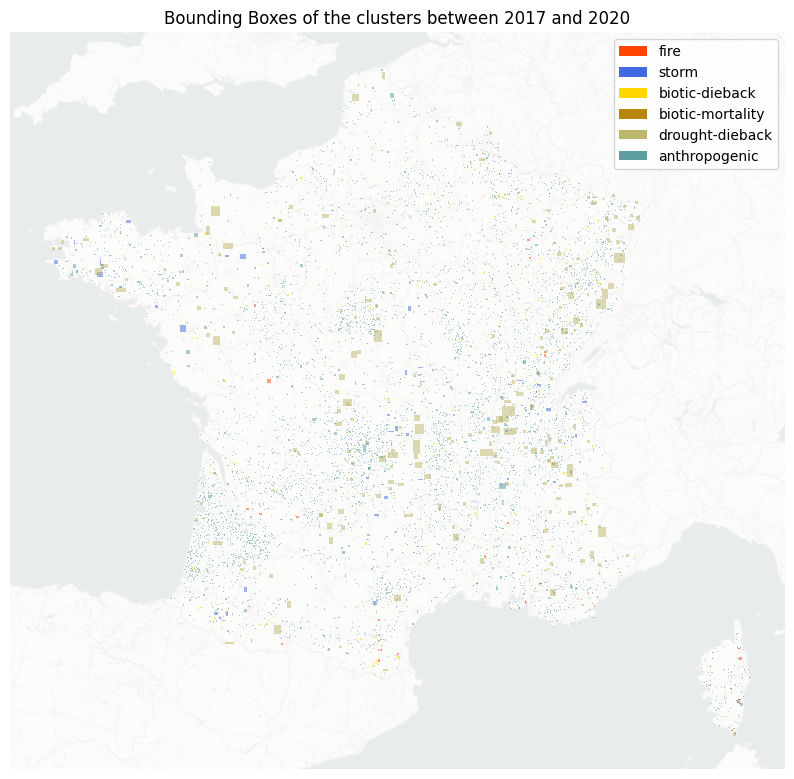

In [18]:
#plot the boxes
custom_color_mapping = {
    'fire': 'orangered',
    'storm': 'royalblue',
    'biotic-dieback': 'gold',
    'biotic-mortality': 'darkgoldenrod',  # Yellow-brown
    'drought-dieback': 'darkkhaki',
    'anthropogenic': 'cadetblue'  # Light blue/grey
}

#make a nice plot with fig, ax
import matplotlib.pyplot as plt
import contextily as ctx
fig, ax = plt.subplots(figsize=(10, 10))
for class_, color in custom_color_mapping.items():
    boxes_class[ boxes_class['class'] == class_ ].plot(ax=ax, color=color, alpha=0.5, label=class_)
ax.set_title('Bounding Boxes of the clusters between 2017 and 2020')
ax.set_axis_off()
#add legend from custom_color_mapping, create a list of patches with the color and the label
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=class_) for class_, color in custom_color_mapping.items()]
ax.legend(handles=legend_elements)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, attribution=False, crs=communities.crs.to_string(), alpha=0.5)
fig.savefig('../figures/bounding_boxes_clusters2.png', dpi=300, bbox_inches='tight')

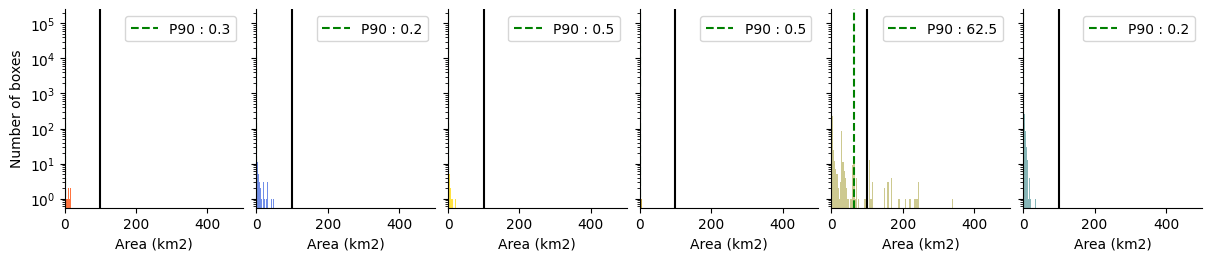

In [19]:

#from geodataframe of boxes, 
#compute the area of each geometry, convert it to square kilometers and add it to the geodataframe as a new column 'area_km2'
boxes_class['area_km2'] = boxes_class.area / 10**6

#histogram of size distribution per class 
#plot the distribution of the area of the boxes in logscale
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(custom_color_mapping), figsize=(len(custom_color_mapping)*2, 2.5), sharey=True, sharex=True, constrained_layout=True)
for ax, (class_, color) in zip(axes, custom_color_mapping.items()):
    area = boxes_class[boxes_class['class'] == class_].area_km2
    ax.hist(area, bins=100, log=True, alpha=0.75, color=color)
    ax.set_xlabel('Area (km2)')
    ax.set_xlim(0, 500)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #add median and percentile 90 to the plot WITH THEIR VALUES in label 
    percentile_90 = area.quantile(0.9)
    ax.axvline(percentile_90, color='g', linestyle='--', label=f'P90 : {percentile_90:.1f}')
    #add vertical line at 100 for maximum bounding box area with sentinel2 for labelling
    ax.axvline(100, color='black')
    ax.legend()

axes[0].set_ylabel('Number of boxes')
fig.savefig('../figures/area_distribution_clusters2.png', dpi=300, bbox_inches='tight')


## 3. Distribution of cluster size per forest habitat

In [20]:
#read dbf with geopandas

greco = gpd.read_file('/Users/arthurcalvi/Data/eco-regions/France/ser_l93_new/ser_l93_new.dbf')
greco['greco'] = greco.codeser.apply(lambda x:x[0])
greco = greco.dissolve(by='greco', aggfunc='first')
greco = greco.reset_index().iloc[1:].to_crs('EPSG:2154')

<Axes: >

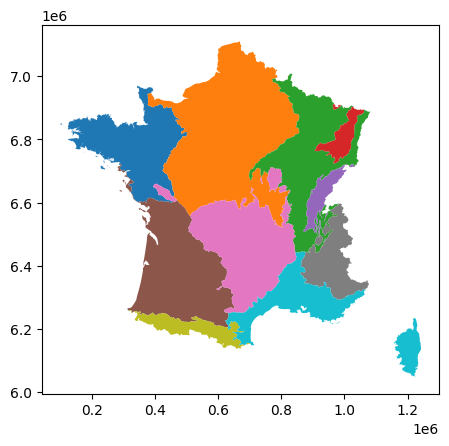

In [21]:
greco.plot(column='greco')


In [22]:
len(greco)

11

11it [10:37, 57.98s/it]


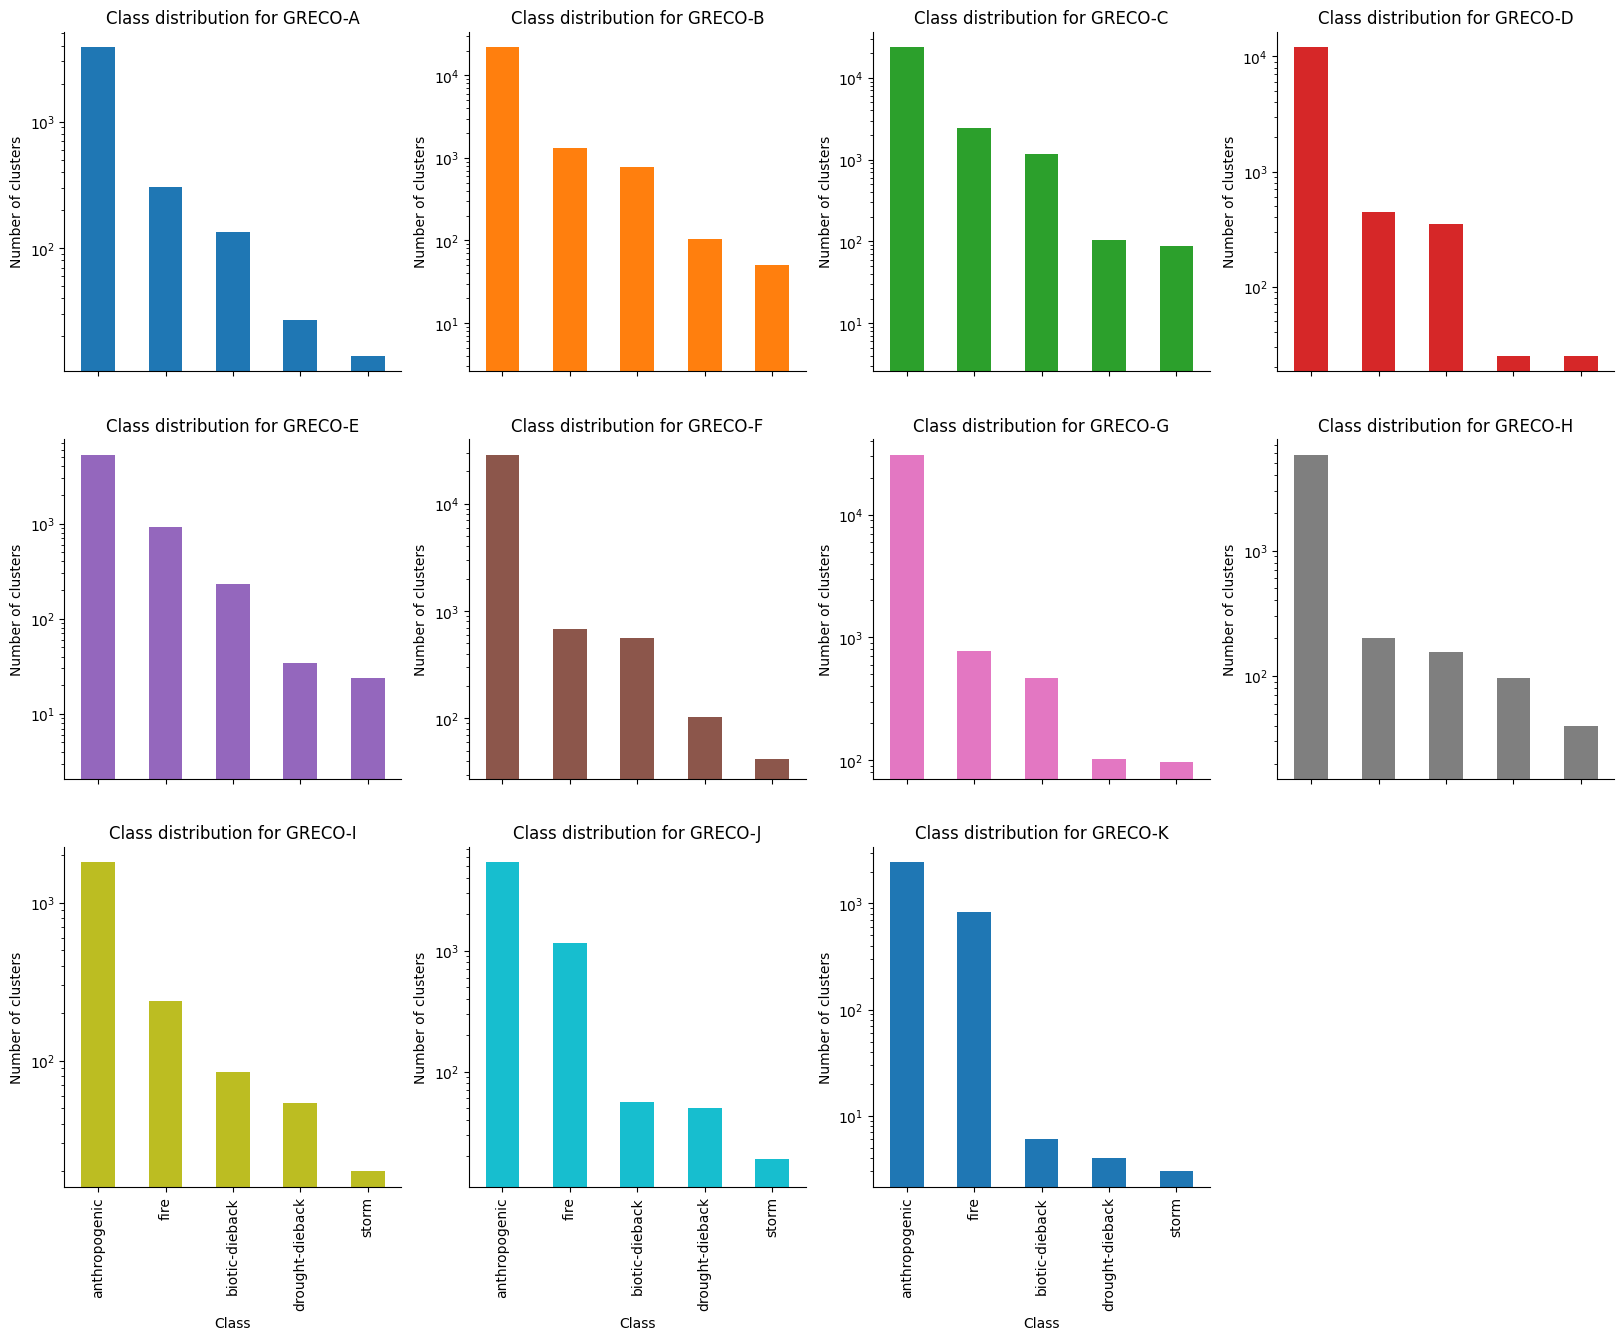

In [23]:
# fig, ax = plt.subplots(1, 1, figsize=(10,10)) 
#build grid for 11 plots
fig, axes = plt.subplots(3, 4, figsize=(20, 15), sharex=True)

#iterate over the rows of the greco geodataframe 
for i, (row, ax) in tqdm(enumerate(zip(greco.itertuples(), axes.flatten()))):
    region = row.geometry
    g = row.greco 
    clusters_region = boxes_class.clip(region)
    
    #histogram of Class distribution
    clusters_region['class'].value_counts().plot(kind='bar', ax=ax, logy=True, color=f'C{i}')
    ax.set_title(f'Class distribution for GRECO-{g}')
    ax.set_xlabel('Class')
    ax.set_ylabel('Number of clusters')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

#delete last ax
ax = axes.flatten()[-1]
greco.plot(column='greco', ax=ax)
ax.set_axis_off()


In [ ]:
fig.savefig('../figures/class_distribution_clusters_per_greco2.png', dpi=300, bbox_inches='tight')

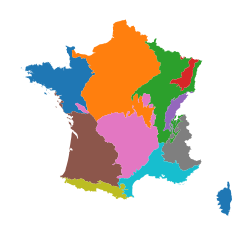

In [169]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
for i,row in enumerate(greco.itertuples()):
    gdf = gpd.GeoDataFrame([row])
    gdf.plot(color=f'C{i}', ax=ax)
ax.set_axis_off()